In [204]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [205]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.preprocessing import StandardScaler

from pmdarima import auto_arima
from scipy.stats import norm
from calendar import monthrange
from holidays import Netherlands as nl_vak

# Custom transformer import
from custom_modules.custom_transformers import TimeSeriesTransformer

In [206]:
pd.options.display.max_columns = None
%matplotlib inline
sns.set(style="darkgrid")
random_seed = 42

In [207]:
columns = ['Datetime_UTC', 'Demand_m3', 'Data_status']
df = pd.read_csv('data/Water_usage_minute_2010_2020.txt', names=columns, header=None, delimiter='|')
df.head()

KeyboardInterrupt: 

In [5]:
df['Datetime_UTC'] = df['Datetime_UTC'].apply(lambda x: datetime.fromisoformat(x.replace("Z", "+00:00")))
df.head()

,Datetime_UTC,Demand_m3,Data_status
0,2009-12-31 23:00:00+00:00,5872.591797,0
1,2009-12-31 23:01:00+00:00,5864.009766,0
2,2009-12-31 23:02:00+00:00,5855.428223,0
3,2009-12-31 23:03:00+00:00,5846.846191,0
4,2009-12-31 23:04:00+00:00,5838.264648,0


In [6]:
data = df.copy()
data['Datetime_UTC'] = pd.to_datetime(data['Datetime_UTC'], unit='m')
data = data.loc[data.Datetime_UTC.between('2010-01-01', '2020-12-31')]
data.set_index('Datetime_UTC', inplace=True)
data = data.resample('d').sum()/60
#data.index = data.index.date
data = data.fillna(0)
data.head()

,Demand_m3,Data_status
Datetime_UTC,,
2010-01-01 00:00:00+00:00,168366.988411,0.0
2010-01-02 00:00:00+00:00,169425.485075,0.0
2010-01-03 00:00:00+00:00,176486.602049,0.0
2010-01-04 00:00:00+00:00,182879.800460,0.0
2010-01-05 00:00:00+00:00,179537.108252,0.0


In [16]:
def ts_analysis_plots(data, n_lags):  
    
    # AD Fuller test and linear trend of the time series
    trend, coefs = TimeSeriesTransformer.get_trend(data)
    a, b = coefs[0], coefs[1]
    adf = adfuller(data)
    
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    axs = axs.flat

    # combine original timeseries with trendline
    df = pd.concat([data, trend], axis=1)

    # calculate a 12 period rolling mean
    df['rolling_mean'] = data.rolling(12, min_periods=1).mean()

    # calculate a 12 period rolling standard deviation
    df['rolling_std'] = data.rolling(12, min_periods=1).std()

    # plot dataframe columns against time
    sns.lineplot(data=df, ax=axs[0])
    axs[0].set(xlabel=data.index.name, ylabel=data.name, 
               title="Timeseries plot of data (ADF p-value: {:.3f}) \n \
                    (Trend: a={:.0f}, b={:.0f})".format(adf[1], coefs[0], coefs[1]))
        
    # histogram of value distribution
    sns.distplot(data, bins=20, hist=True, kde=True, rug=False, fit=norm, ax=axs[1],
                kde_kws={"label": "KDE"})
    axs[1].set(xlabel=data.name, ylabel="probability", title="Distribution of dataset")
    
    # autocorrelation function
    plot_acf(data, lags=n_lags, ax=axs[2])
    axs[2].set(xlabel="lag", ylabel="ACF value")
    
    # partial autocorrelation function
    plot_pacf(data, lags=n_lags, ax=axs[3])
    axs[3].set(xlabel="lag", ylabel="PACF value")
    
    plt.tight_layout()
    plt.show()

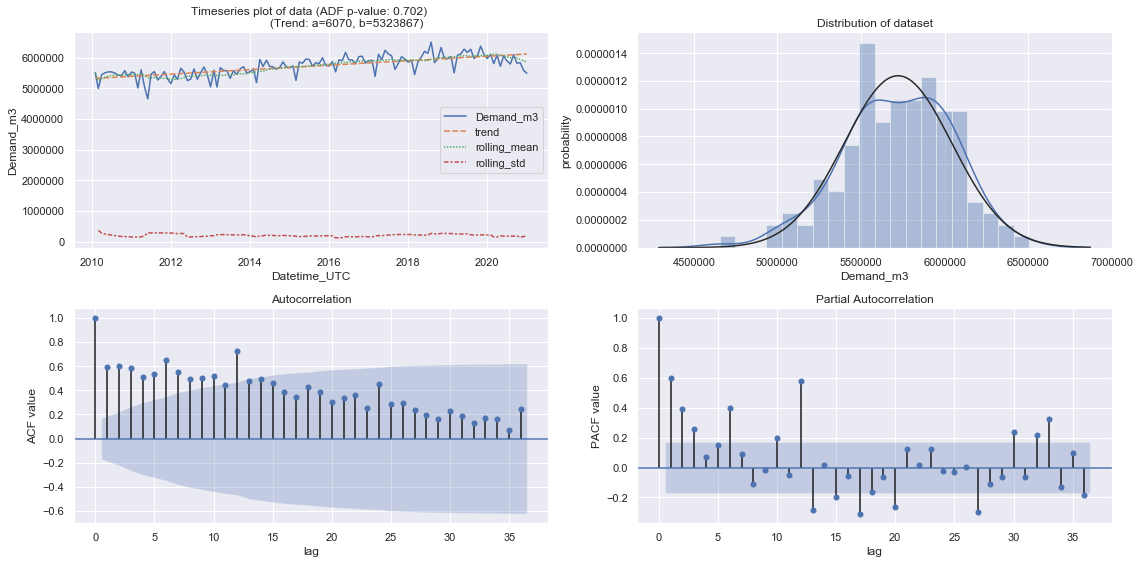

ADF Statistic: -1.13
p-value: 0.70
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


In [17]:
y = data.resample('M').sum()['Demand_m3']

# Generate plots and calculate ADF values
ts_analysis_plots(y, 36)

# check if dataframe is stationary
result = adfuller(y)
print('ADF Statistic: {:.2f}'.format(result[0]))
print('p-value: {:.2f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

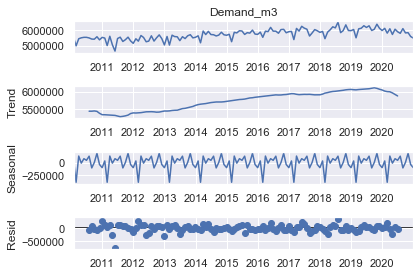

In [9]:
result = seasonal_decompose(y, model='additive', freq=12)
result.plot()

plt.show()

In [18]:
data['year'] = data.index.year
data['week_no'] = pd.Series(data.index.date).apply(lambda x: x.isocalendar()[1]).tolist()
data['day_of_yr'] = pd.Series(data.index.date).apply(lambda x: x.timetuple().tm_yday).tolist()
data['day_of_wk'] = pd.Series(data.index.date).apply(lambda x: x.weekday()).tolist()
data['is_holiday'] = pd.Series(data.index.date).apply(lambda x: x in nl_vak(years=x.year)).astype(int).tolist()
data = pd.get_dummies(data, columns=['day_of_wk'])
data.head()

,Demand_m3,Data_status,year,week_no,day_of_yr,is_holiday,day_of_wk_0,day_of_wk_1,day_of_wk_2,day_of_wk_3,day_of_wk_4,day_of_wk_5,day_of_wk_6
Datetime_UTC,,,,,,,,,,,,,
2010-01-01 00:00:00+00:00,168366.988411,0.0,2010,53,1,1,0,0,0,0,1,0,0
2010-01-02 00:00:00+00:00,169425.485075,0.0,2010,53,2,0,0,0,0,0,0,1,0
2010-01-03 00:00:00+00:00,176486.602049,0.0,2010,53,3,0,0,0,0,0,0,0,1
2010-01-04 00:00:00+00:00,182879.800460,0.0,2010,1,4,0,1,0,0,0,0,0,0
2010-01-05 00:00:00+00:00,179537.108252,0.0,2010,1,5,0,0,1,0,0,0,0,0


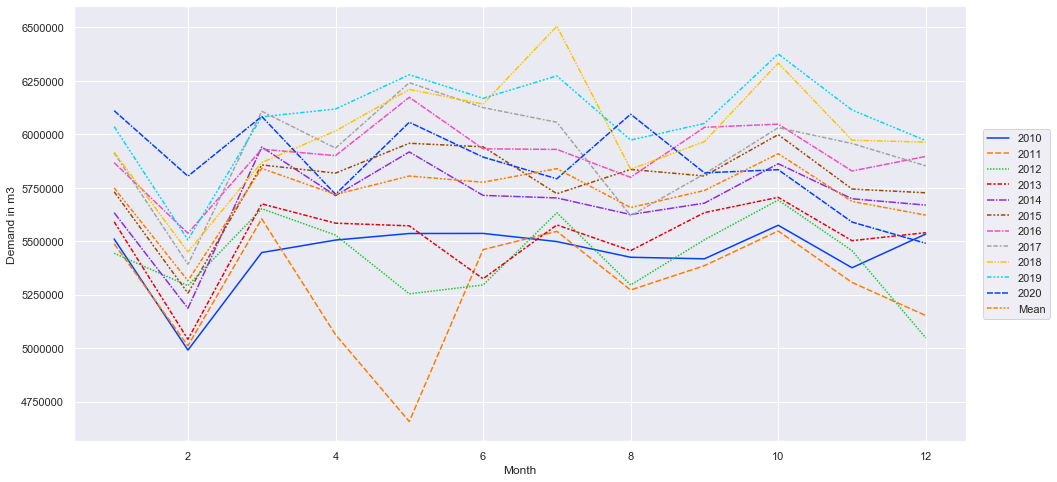

In [14]:
# Plot yearly seasonal trend
df2 = pd.pivot_table(data, index=data.index.month, columns=data.year, values='Demand_m3', aggfunc=np.sum)
df2['Mean'] = df2.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df2, ax=ax, palette='bright')
ax.set(xlabel='Month', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

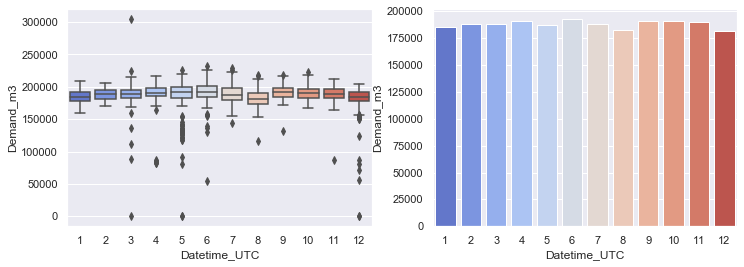

In [15]:
df_monthly = data.copy()
df_monthly.index = df_monthly.index.month
df_averages = df_monthly.groupby(df_monthly.index).mean()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs = axs.flat

sns.boxplot(x=df_monthly.index, y="Demand_m3", palette="coolwarm", data=df_monthly, ax=axs[0])
sns.barplot(x=df_averages.index, y="Demand_m3", palette="coolwarm", data=df_averages, ax=axs[1])

#plt.tight_layout()
plt.show()

In [16]:
df_yearly = data.groupby(data.index.year).sum()['Demand_m3']
df_yearly

Datetime_UTC
2010    6.535232e+07
2011    6.349633e+07
2012    6.509852e+07
2013    6.620267e+07
2014    6.834208e+07
2015    6.939674e+07
2016    7.087534e+07
2017    7.104664e+07
2018    7.217971e+07
2019    7.294843e+07
2020    7.028964e+07
Name: Demand_m3, dtype: float64

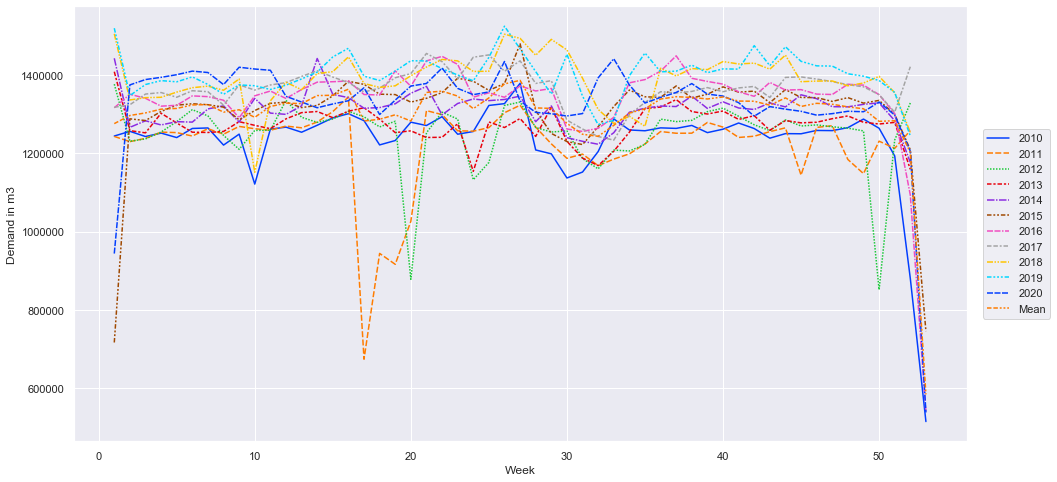

In [17]:
# Plot weekly seasonal trend
df3 = pd.pivot_table(data, index=data.week_no, columns=data.year, values='Demand_m3', aggfunc=np.sum)
df3['Mean'] = df3.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df3, ax=ax, palette='bright')
ax.set(xlabel='Week', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

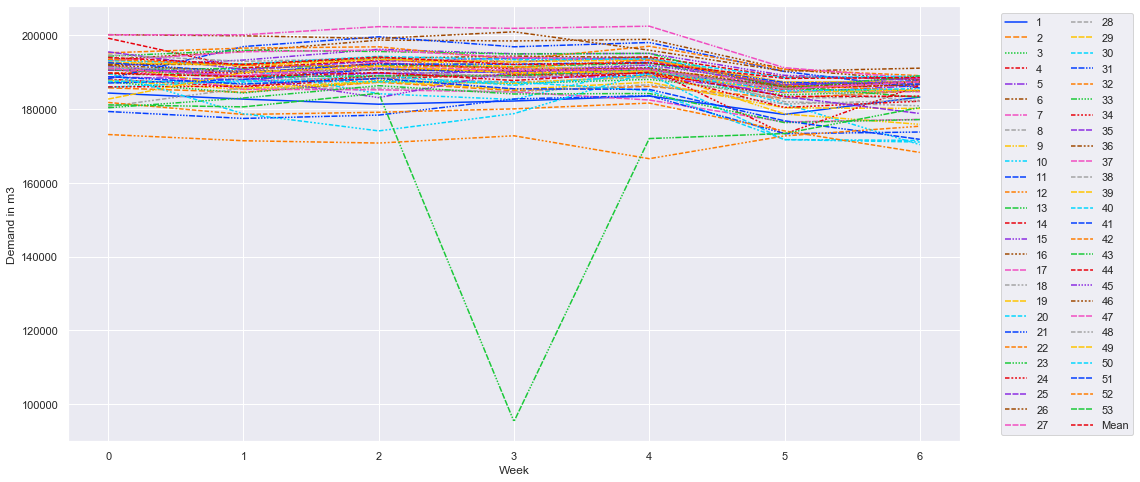

In [447]:
# Plot day of week seasonal trend
df4 = pd.pivot_table(data, index=data.day_of_wk, columns=data.week_no, values='Demand_m3', aggfunc=np.average)
df4['Mean'] = df4.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df4, ax=ax, palette='bright')
ax.set(xlabel='Week', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=2)

plt.show()

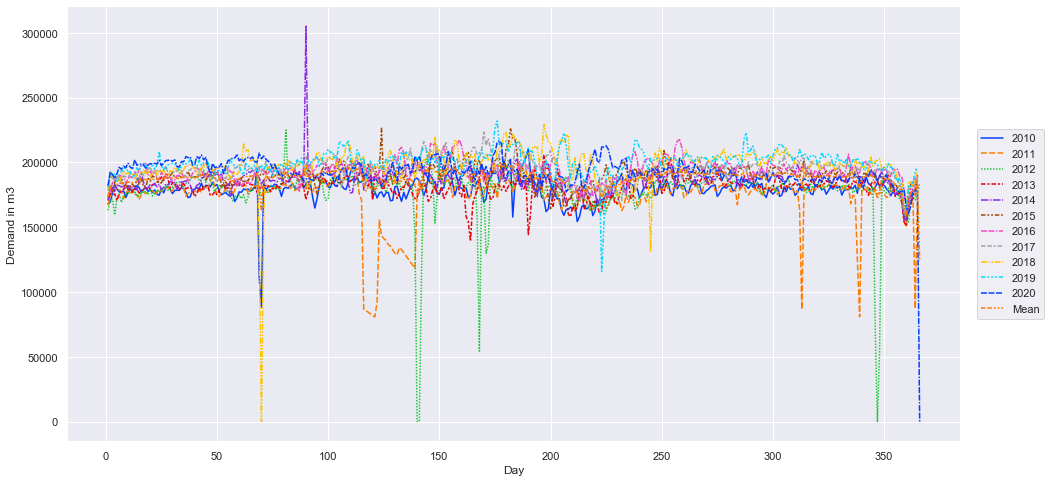

In [448]:
# Plot daily seasonal trend
df5 = pd.pivot_table(data, index=data.day_of_yr, columns=data.year, values='Demand_m3', aggfunc=np.sum)
df5['Mean'] = df5.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df5, ax=ax, palette='bright')
ax.set(xlabel='Day', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

In [19]:
def trim_outliers(df, value, grouper, q1=0.25, q3=0.75, iqr=1.5):
    # Function to filter outliers iteratively, based on boxplots and IQR
    n = 1
    
    while n > 0:
        df_grouped = df.groupby(df[grouper])[value]
        Q1 = df_grouped.quantile(q1)
        Q3 = df_grouped.quantile(q3)
        IQR = iqr * (Q3 - Q1)

        df = df.drop('min_whis', axis=1, errors='ignore').join((Q1 - IQR).rolling(3, min_periods=1).mean().rename(\
            'min_whis'), on='day_of_yr') 
        df = df.drop('max_whis', axis=1, errors='ignore').join((Q3 + IQR).rolling(3, min_periods=1).mean().rename(\
            'max_whis'), on='day_of_yr') 

        n = sum((df[value] < df['min_whis']) | (df[value] > df['max_whis']))
        print('number of outliers to trim: {}'.format(n))

        df[value].mask( (df[value] < df['min_whis']) | (df[value] > df['max_whis']), inplace=True)
    return df

In [20]:
df_daily = trim_outliers(data, 'Demand_m3', 'day_of_yr')
df_daily['Demand_m3'].interpolate(method='linear', inplace=True)
df_daily

number of outliers to trim: 89
number of outliers to trim: 12
number of outliers to trim: 7
number of outliers to trim: 4
number of outliers to trim: 5
number of outliers to trim: 6
number of outliers to trim: 6
number of outliers to trim: 2
number of outliers to trim: 1
number of outliers to trim: 0


,Demand_m3,Data_status,year,week_no,day_of_yr,is_holiday,day_of_wk_0,day_of_wk_1,day_of_wk_2,day_of_wk_3,day_of_wk_4,day_of_wk_5,day_of_wk_6,min_whis,max_whis
Datetime_UTC,,,,,,,,,,,,,,,
2010-01-01 00:00:00+00:00,168366.988411,0.0,2010,53,1,1,0,0,0,0,1,0,0,155212.462475,193136.905554
2010-01-02 00:00:00+00:00,169425.485075,0.0,2010,53,2,0,0,0,0,0,0,1,0,152377.936939,204052.241388
2010-01-03 00:00:00+00:00,176486.602049,0.0,2010,53,3,0,0,0,0,0,0,0,1,154553.823249,204724.696414
2010-01-04 00:00:00+00:00,182879.800460,0.0,2010,1,4,0,1,0,0,0,0,0,0,157241.514917,207909.637444
2010-01-05 00:00:00+00:00,179537.108252,0.0,2010,1,5,0,0,1,0,0,0,0,0,162850.245029,203516.517291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27 00:00:00+00:00,166527.767712,0.0,2020,52,362,0,0,0,0,0,0,0,1,154897.441454,174953.118392
2020-12-28 00:00:00+00:00,172157.567014,0.0,2020,53,363,0,1,0,0,0,0,0,0,163949.762102,175180.724206
2020-12-29 00:00:00+00:00,177787.366315,0.0,2020,53,364,0,0,1,0,0,0,0,0,167609.556190,178553.047563


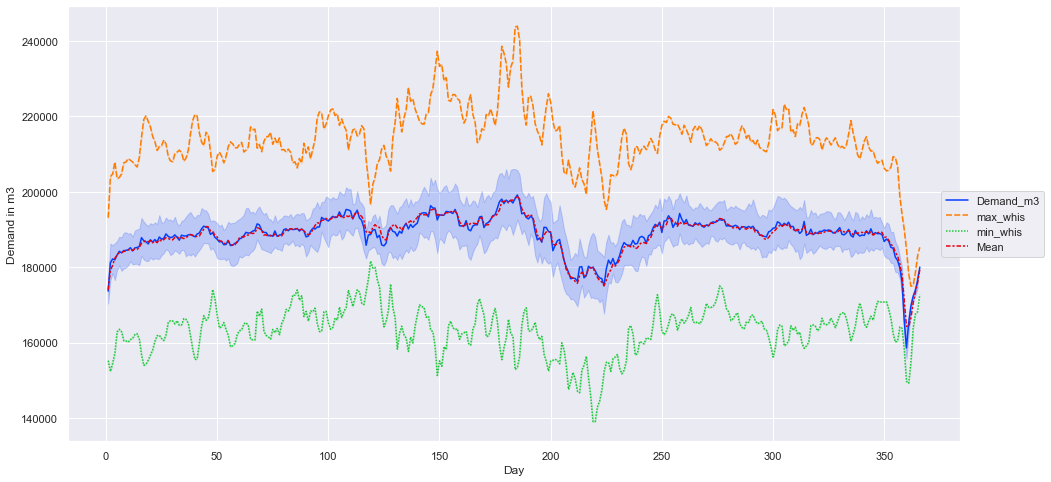

In [21]:
columns = ['Demand_m3', 'year', 'day_of_yr', 'min_whis', 'max_whis']
df6 = pd.pivot_table(df_daily[columns].loc[df_daily.year <= 2020], index='day_of_yr', columns='year', aggfunc=np.sum)
df6['Mean'] = df6.mean(axis=1)

fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df6, ax=ax, palette='bright')
ax.set(xlabel='Day', ylabel='Demand in m3')

# Put a legend to the right side
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5), ncol=1)

plt.show()

In [147]:
weekdays = ['day_of_wk_' + x.astype(str) for x in np.arange(0,7)]
df_trimmed = df_daily.resample('M').sum()[['Demand_m3', 'is_holiday'] + weekdays]
# adding timeseries exogenous variables
df_trimmed['days_in_month'] = df_trimmed.index.map(lambda x: monthrange(x.year, x.month)[1])
df_trimmed.head()

,Demand_m3,is_holiday,day_of_wk_0,day_of_wk_1,day_of_wk_2,day_of_wk_3,day_of_wk_4,day_of_wk_5,day_of_wk_6,days_in_month
Datetime_UTC,,,,,,,,,,
2010-01-31 00:00:00+00:00,5.510467e+06,1,4,4,4,4,5,5,5,31
2010-02-28 00:00:00+00:00,4.990807e+06,0,4,4,4,4,4,4,4,28
2010-03-31 00:00:00+00:00,5.628360e+06,0,5,5,5,4,4,4,4,31
2010-04-30 00:00:00+00:00,5.530608e+06,4,4,4,4,5,5,4,4,30
2010-05-31 00:00:00+00:00,5.555788e+06,4,5,4,4,4,4,5,5,31


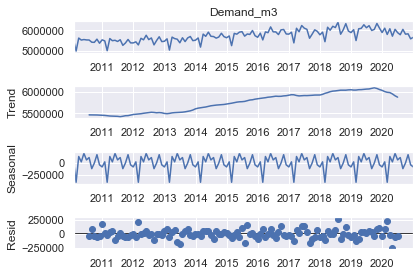

In [148]:
y = df_trimmed['Demand_m3']
result = seasonal_decompose(y, model='additive', freq=12)
result.plot()

plt.show()

In [149]:
# loading weather data
exog = pd.read_csv('data/exog_ts_features.csv', sep=';', decimal=',')
exog['Datetime_UTC'] = pd.to_datetime(exog['date']).apply(lambda x: datetime.fromisoformat(str(x) + "+00:00"))
exog.drop('date', axis=1, inplace=True)
exog.set_index('Datetime_UTC', inplace=True)
exog = exog.resample('M').sum()
exog

,sun_calc_inhours_perday,calctemp_per_day,durationrainhours_perday
Datetime_UTC,,,
2010-01-31 00:00:00+00:00,97.5,116.6,37.50
2010-02-28 00:00:00+00:00,78.5,149.3,67.44
2010-03-31 00:00:00+00:00,136.1,278.4,38.58
2010-04-30 00:00:00+00:00,240.0,304.7,14.82
2010-05-31 00:00:00+00:00,224.2,345.4,23.10
...,...,...,...
2021-08-31 00:00:00+00:00,4.0,1.6,1.08
2021-09-30 00:00:00+00:00,5.0,0.1,0.00
2021-10-31 00:00:00+00:00,1.7,2.8,0.00


In [150]:
# combining timeseries and weather exogenous variables
df_trimmed = df_trimmed.join(exog, how='left')
df_trimmed.head()

,Demand_m3,is_holiday,day_of_wk_0,day_of_wk_1,day_of_wk_2,day_of_wk_3,day_of_wk_4,day_of_wk_5,day_of_wk_6,days_in_month,sun_calc_inhours_perday,calctemp_per_day,durationrainhours_perday
Datetime_UTC,,,,,,,,,,,,,
2010-01-31 00:00:00+00:00,5.510467e+06,1,4,4,4,4,5,5,5,31,97.5,116.6,37.50
2010-02-28 00:00:00+00:00,4.990807e+06,0,4,4,4,4,4,4,4,28,78.5,149.3,67.44
2010-03-31 00:00:00+00:00,5.628360e+06,0,5,5,5,4,4,4,4,31,136.1,278.4,38.58
2010-04-30 00:00:00+00:00,5.530608e+06,4,4,4,4,5,5,4,4,30,240.0,304.7,14.82
2010-05-31 00:00:00+00:00,5.555788e+06,4,5,4,4,4,4,5,5,31,224.2,345.4,23.10


In [151]:
# Setting train and test sets
train, test = df_trimmed.loc['2010':'2018'], df_trimmed.loc['2019'::]
print(train.shape, test.shape)

(108, 13) (24, 13)


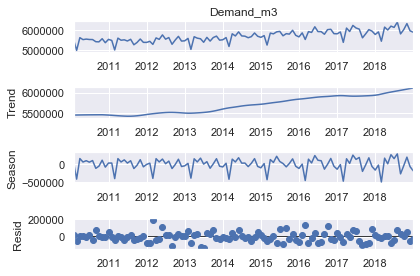

In [152]:
stl = STL(train.Demand_m3, period=12).fit()
stl.plot()

plt.show()

In [153]:
train['trend'] = stl.trend# - train.Demand_m3.mean()
train.head()

,Demand_m3,is_holiday,day_of_wk_0,day_of_wk_1,day_of_wk_2,day_of_wk_3,day_of_wk_4,day_of_wk_5,day_of_wk_6,days_in_month,sun_calc_inhours_perday,calctemp_per_day,durationrainhours_perday,trend
Datetime_UTC,,,,,,,,,,,,,,
2010-01-31 00:00:00+00:00,5.510467e+06,1,4,4,4,4,5,5,5,31,97.5,116.6,37.50,5.458708e+06
2010-02-28 00:00:00+00:00,4.990807e+06,0,4,4,4,4,4,4,4,28,78.5,149.3,67.44,5.460382e+06
2010-03-31 00:00:00+00:00,5.628360e+06,0,5,5,5,4,4,4,4,31,136.1,278.4,38.58,5.461830e+06
2010-04-30 00:00:00+00:00,5.530608e+06,4,4,4,4,5,5,4,4,30,240.0,304.7,14.82,5.463046e+06
2010-05-31 00:00:00+00:00,5.555788e+06,4,5,4,4,4,4,5,5,31,224.2,345.4,23.10,5.464033e+06


In [154]:
# deflate timeseries
#train['trf_demand'] = train['Demand_m3'] - train['trend']

# initialize a transformer class
TT = TimeSeriesTransformer(log=False, detrend=False, diff=True, scale=False)

# detrend and perform differencing on both 1 and 12 periods
train['trf_demand'] = TT.fit_transform(train.index, train.Demand_m3, [1])

train.head(15)

,Demand_m3,is_holiday,day_of_wk_0,day_of_wk_1,day_of_wk_2,day_of_wk_3,day_of_wk_4,day_of_wk_5,day_of_wk_6,days_in_month,sun_calc_inhours_perday,calctemp_per_day,durationrainhours_perday,trend,trf_demand
Datetime_UTC,,,,,,,,,,,,,,,
2010-01-31 00:00:00+00:00,5.510467e+06,1,4,4,4,4,5,5,5,31,97.5,116.6,37.50,5.458708e+06,NaN
2010-02-28 00:00:00+00:00,4.990807e+06,0,4,4,4,4,4,4,4,28,78.5,149.3,67.44,5.460382e+06,-519659.723879
2010-03-31 00:00:00+00:00,5.628360e+06,0,5,5,5,4,4,4,4,31,136.1,278.4,38.58,5.461830e+06,637552.181586
2010-04-30 00:00:00+00:00,5.530608e+06,4,4,4,4,5,5,4,4,30,240.0,304.7,14.82,5.463046e+06,-97751.524542
2010-05-31 00:00:00+00:00,5.555788e+06,4,5,4,4,4,4,5,5,31,224.2,345.4,23.10,5.464033e+06,25179.830637
2010-06-30 00:00:00+00:00,5.536639e+06,0,4,5,5,4,4,4,4,30,263.5,407.1,10.74,5.464799e+06,-19149.404669
2010-07-31 00:00:00+00:00,5.533176e+06,0,4,4,4,5,5,5,4,31,179.7,449.1,24.00,5.465375e+06,-3462.085870
2010-08-31 00:00:00+00:00,5.425033e+06,0,5,5,4,4,4,4,5,31,135.0,421.1,42.84,5.465828e+06,-108143.839087
2010-09-30 00:00:00+00:00,5.417805e+06,0,4,4,5,5,4,4,4,30,136.0,351.1,44.16,5.466332e+06,-7227.602568


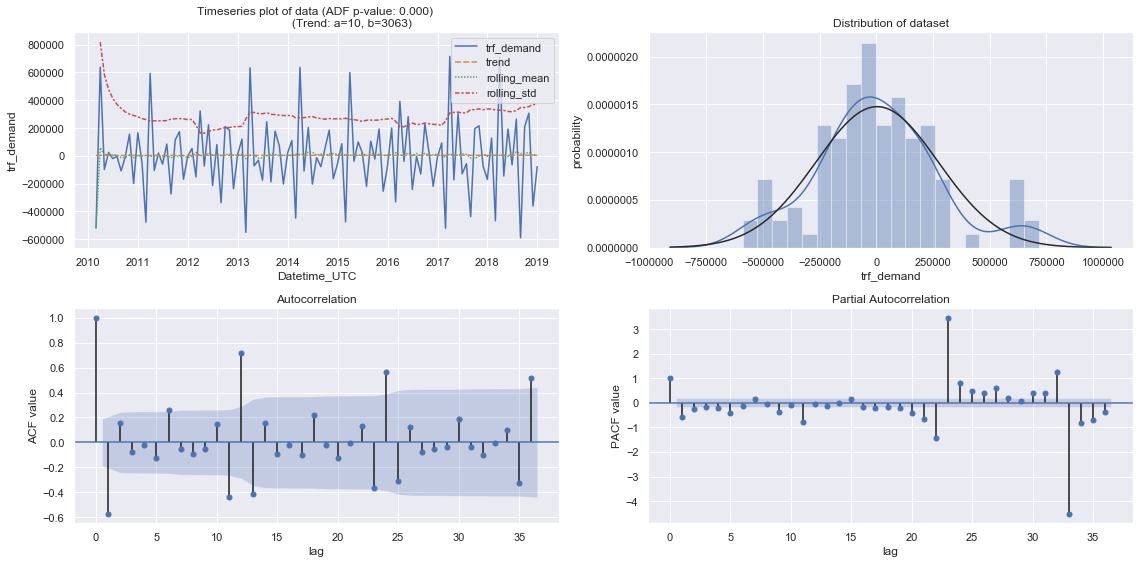

ADF Statistic: -1.26
p-value: 0.65
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


In [413]:
# Selecting train and test arrays
features = ['days_in_month', 'is_holiday', 'sun_calc_inhours_perday', 'calctemp_per_day', 'durationrainhours_perday'] + weekdays#, 'durationrainhours_perday']# + weekdays[5:7]
#'is_holiday',
y_train = train['trf_demand'][1::]
exog_train = train[features][1::]
y_test = test['Demand_m3']
exog_test = test[features]

# Generate plots and calculate ADF values
ts_analysis_plots(y_train, 36)

# check if dataframe is stationary
result = adfuller(y)
print('ADF Statistic: {:.2f}'.format(result[0]))
print('p-value: {:.2f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [414]:
# optimizing hyper parameters
sarima_model = auto_arima(y_train, start_p=1, start_q=1,
                          max_p=12, max_d=3, max_q=6,
                          seasonal=True, m=12,
                          #stationary=True,
                          trace=True, random_state=42,
                          out_of_sample_size=0,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=2483.985, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2536.016, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2507.474, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2480.495, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2534.724, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2493.754, Time=0.04 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=2482.284, Time=0.24 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=2482.436, Time=0.47 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=2482.598, Time=0.09 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2522.040, Time=0.07 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=2482.250, Time=0.12 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=2487.190, Time=0.17 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=2501.587, Time=0.13 sec
 ARIMA(1,0,2)(0,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  107
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1235.365
Date:                            Thu, 21 Jan 2021   AIC                           2476.730
Time:                                    19:53:45   BIC                           2484.392
Sample:                                         0   HQIC                          2479.826
                                            - 107                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8090      0.102     -7.958      0.000      -1.008      -0.610
ma.S.L12      -0.5162      0.147     -3.507      0.000      -0.805      -0.228
sigma2      1.535e+10   2.03e-12   7.57e+21      0.000    1.53e+10    1.53e+10
===================================================================================
Ljung-Box (Q):                       27.60   Jarque-Bera (JB):                 7.18
Prob(Q):                              0.93   Prob(JB):                         0.03
Heteroskedasticity (H):               1.21   Skew:                             0.08
Prob(H) (two-sided):                  0.60   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [565]:
# (0, 0, 3)x(0, 1, 1, 12) seems to be the best option
# (1, 0, 3)x,(0, 1, 1)x12 best with differencing [1]
mod = sm.tsa.statespace.SARIMAX(y_train,
                                exog=exog_train,
                                order=(2, 0, 5),
                                seasonal_order=(0, 1, 1, 12),
                                trend='n',
                                mle_regression=True,
                                enforce_stationarity=True,
                                enforce_invertibility=True)
results = mod.fit()
print(results.summary())#.tables[1])

/Users/sebas/.pyenv/versions/3.8.1/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
                                      SARIMAX Results                                       
Dep. Variable:                           trf_demand   No. Observations:                  107
Model:             SARIMAX(2, 0, 5)x(0, 1, [1], 12)   Log Likelihood               -1247.918
Date:                              Thu, 21 Jan 2021   AIC                           2537.835
Time:                                      20:08:25   BIC                           2591.467
Sample:                                  02-28-2010   HQIC                          2559.506
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
          

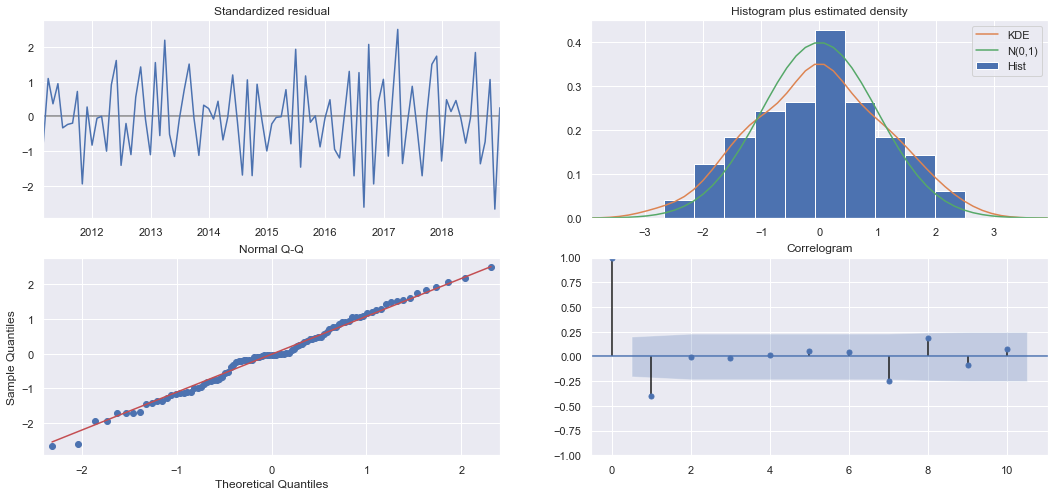

In [566]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

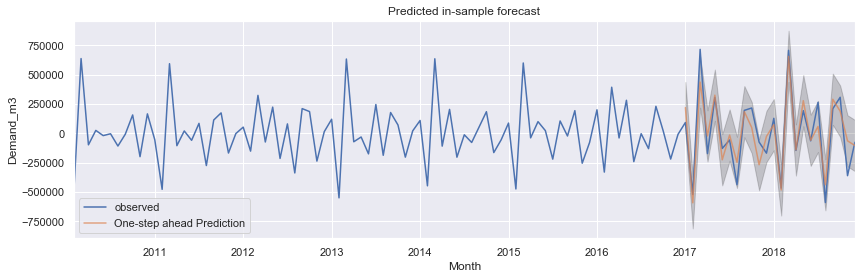

In [578]:
pred = results.get_prediction(start=datetime(2017, 1, 31).replace(tzinfo=timezone.utc), dynamic=False)

pred_ci = pred.conf_int(alpha=0.05)
ax = y_train.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Prediction', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_title('Predicted in-sample forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Demand_m3')
plt.legend()
plt.show()

In [568]:
y_hat = pred.predicted_mean
y_truth = y_train['2017':'2018']
mse = ((y_hat - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 18439716953.95
The Root Mean Squared Error is 135792.92


In [569]:
pred_uc = results.get_forecast(steps=y_test.shape[0], exog=exog_test)
df_pred = pred_uc.summary_frame().rename(columns={'mean': 'y_hat', 'mean_se': 'y_hat_se'})
df_pred

trf_demand,y_hat,y_hat_se,mean_ci_lower,mean_ci_upper
2019-01-31 00:00:00+00:00,85482.651285,111360.474689,-132779.868407,3.037452e+05
2019-02-28 00:00:00+00:00,-435333.291944,111434.996512,-653741.871725,-2.169247e+05
2019-03-31 00:00:00+00:00,758034.734302,111454.365822,539588.191372,9.764813e+05
2019-04-30 00:00:00+00:00,-155866.721572,111454.616630,-374313.756077,6.258031e+04
2019-05-31 00:00:00+00:00,152200.669065,111485.348111,-66306.598037,3.707079e+05
2019-06-30 00:00:00+00:00,-65332.176217,111485.453677,-283839.650224,1.531753e+05
2019-07-31 00:00:00+00:00,163620.142816,111508.931823,-54933.347512,3.821736e+05
2019-08-31 00:00:00+00:00,-553411.308947,111515.182910,-771977.051180,-3.348456e+05
2019-09-30 00:00:00+00:00,198982.678711,111525.587400,-19603.455947,4.175688e+05
2019-10-31 00:00:00+00:00,247653.330674,111539.438589,29040.048185,4.662666e+05


In [570]:
# append df_pred to data
df_com = train.append(test)
df_com = df_com.join(df_pred, how='left')
df_com.tail()

,Demand_m3,is_holiday,day_of_wk_0,day_of_wk_1,day_of_wk_2,day_of_wk_3,day_of_wk_4,day_of_wk_5,day_of_wk_6,days_in_month,sun_calc_inhours_perday,calctemp_per_day,durationrainhours_perday,trend,trf_demand,y_hat,y_hat_se,mean_ci_lower,mean_ci_upper
Datetime_UTC,,,,,,,,,,,,,,,,,,,
2020-08-31 00:00:00+00:00,6.052575e+06,0,5,4,4,4,4,5,5,31,150.2,519.6,37.02,NaN,NaN,-530033.437605,157408.208295,-838547.856735,-221519.018475
2020-09-30 00:00:00+00:00,5.819868e+06,0,4,5,5,4,4,4,4,30,184.6,438.0,37.56,NaN,NaN,203357.418308,157409.132825,-105158.812867,511873.649482
2020-10-31 00:00:00+00:00,5.834674e+06,0,4,4,4,5,5,5,4,31,106.8,354.7,36.84,NaN,NaN,222514.496918,157412.127004,-86007.602739,531036.596575
2020-11-30 00:00:00+00:00,5.589685e+06,0,5,4,4,4,4,4,5,30,112.6,289.4,33.36,NaN,NaN,-287707.124178,157412.133057,-596229.235698,20814.987342
2020-12-31 00:00:00+00:00,5.665218e+06,2,4,5,5,5,4,4,4,31,107.3,271.1,50.88,NaN,NaN,-105709.184971,157414.674860,-414236.278336,202817.908393


In [571]:
OLS = TT.get_trend(df_com.trend['2018'])
last = df_com.loc[df_com.trend.notna()].trend.tolist()[-1]
extrap = df_com.loc[df_com.trend.isna()].trend.tolist()


for i, x in enumerate(extrap):
    extrap[i] = last + (i + 1) * OLS[1][0]

extrap

[6123243.5346455,
 6137789.782695437,
 6152336.030745374,
 6166882.278795311,
 6181428.526845248,
 6195974.774895186,
 6210521.022945123,
 6225067.27099506,
 6239613.519044997,
 6254159.767094934,
 6268706.0151448725,
 6283252.26319481,
 6297798.511244747,
 6312344.759294684,
 6326891.007344621,
 6341437.255394558,
 6355983.503444496,
 6370529.751494433,
 6385075.99954437,
 6399622.247594307,
 6414168.495644244,
 6428714.743694182,
 6443260.991744119,
 6457807.239794056]

In [572]:
df_com.trend = df_com.loc[df_com.trend.notna()].trend.tolist() + extrap
df_com.trend

Datetime_UTC
2010-01-31 00:00:00+00:00    5.458708e+06
2010-02-28 00:00:00+00:00    5.460382e+06
2010-03-31 00:00:00+00:00    5.461830e+06
2010-04-30 00:00:00+00:00    5.463046e+06
2010-05-31 00:00:00+00:00    5.464033e+06
                                 ...     
2020-08-31 00:00:00+00:00    6.399622e+06
2020-09-30 00:00:00+00:00    6.414168e+06
2020-10-31 00:00:00+00:00    6.428715e+06
2020-11-30 00:00:00+00:00    6.443261e+06
2020-12-31 00:00:00+00:00    6.457807e+06
Freq: M, Name: trend, Length: 132, dtype: float64

In [573]:
# inverse detrend and differencing dataset
df_com['y_pred'] = TT.inverse(df_com.index, df_com.y_hat.fillna(df_com['trf_demand']))# + df_com.trend
df_com['ci_lower'] = df_com.y_pred - abs(df_com.y_hat - df_com.mean_ci_lower)
df_com['ci_upper'] = df_com.y_pred + abs(df_com.mean_ci_upper - df_com.y_hat)
df_com.loc[df_com.y_hat.isna(), ['y_pred', 'ci_lower', 'ci_upper']] = np.nan
df_com.tail(25)

,Demand_m3,is_holiday,day_of_wk_0,day_of_wk_1,day_of_wk_2,day_of_wk_3,day_of_wk_4,day_of_wk_5,day_of_wk_6,days_in_month,sun_calc_inhours_perday,calctemp_per_day,durationrainhours_perday,trend,trf_demand,y_hat,y_hat_se,mean_ci_lower,mean_ci_upper,y_pred,ci_lower,ci_upper
Datetime_UTC,,,,,,,,,,,,,,,,,,,,,,
2018-12-31 00:00:00+00:00,5.896924e+06,2,5,4,4,4,4,5,5,31,75.0,252.5,30.12,6.108697e+06,-75695.443604,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31 00:00:00+00:00,6.036165e+06,1,4,5,5,5,4,4,4,31,106.4,172.7,45.78,6.123244e+06,NaN,85482.651285,111360.474689,-132779.868407,3.037452e+05,5.982406e+06,5.764144e+06,6.200669e+06
2019-02-28 00:00:00+00:00,5.506291e+06,0,4,4,4,4,4,4,4,28,174.5,259.1,14.58,6.137790e+06,NaN,-435333.291944,111434.996512,-653741.871725,-2.169247e+05,5.547073e+06,5.328664e+06,5.765482e+06
2019-03-31 00:00:00+00:00,6.081801e+06,0,4,4,4,4,5,5,5,31,146.8,275.7,32.64,6.152336e+06,NaN,758034.734302,111454.365822,539588.191372,9.764813e+05,6.305108e+06,6.086661e+06,6.523554e+06
2019-04-30 00:00:00+00:00,6.104226e+06,4,5,5,4,4,4,4,4,30,211.6,346.5,19.74,6.166882e+06,NaN,-155866.721572,111454.616630,-374313.756077,6.258031e+04,6.149241e+06,5.930794e+06,6.367688e+06
2019-05-31 00:00:00+00:00,6.278876e+06,1,4,4,5,5,5,4,4,31,208.6,378.0,14.52,6.181429e+06,NaN,152200.669065,111485.348111,-66306.598037,3.707079e+05,6.301442e+06,6.082934e+06,6.519949e+06
2019-06-30 00:00:00+00:00,6.133618e+06,2,4,4,4,4,4,5,5,30,211.0,466.1,34.50,6.195975e+06,NaN,-65332.176217,111485.453677,-283839.650224,1.531753e+05,6.236109e+06,6.017602e+06,6.454617e+06
2019-07-31 00:00:00+00:00,6.234629e+06,0,5,5,5,4,4,4,4,31,213.6,522.5,24.60,6.210521e+06,NaN,163620.142816,111508.931823,-54933.347512,3.821736e+05,6.399730e+06,6.181176e+06,6.618283e+06
2019-08-31 00:00:00+00:00,5.998563e+06,0,4,4,4,5,5,5,4,31,226.0,493.3,30.36,6.225067e+06,NaN,-553411.308947,111515.182910,-771977.051180,-3.348456e+05,5.846318e+06,5.627753e+06,6.064884e+06


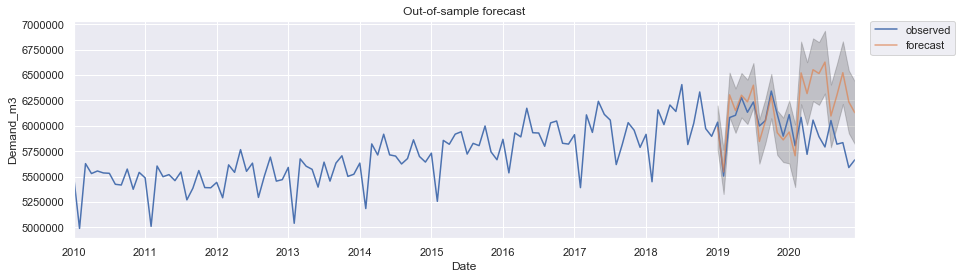

In [579]:
ax = df_com.Demand_m3.plot(label='observed')
df_com.y_pred.plot(ax=ax, label='forecast', alpha=.7, figsize=(14, 4))

ax.fill_between(df_com.index,
                df_com.ci_lower,
                df_com.ci_upper, color='k', alpha=.2)

ax.set_title('Out-of-sample forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Demand_m3')

plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.show()

In [581]:
actual = df_com['2019'].Demand_m3.sum()
forecast = df_com['2019'].y_pred.sum()
error = (forecast - actual) / actual

print('Actual supply in 2019: {:,.0f} m3'.format(actual))
print('Forecasted supply for 2019: {:,.0f} m3'.format(forecast))
print('Total error for 2019: {0:.4%}'.format(error))

Actual supply in 2019: 72,779,780 m3
Forecasted supply for 2019: 72,900,028 m3
Total error for 2019: 0.1652%


In [580]:
actual = df_com['2020'].Demand_m3.sum()
forecast = df_com['2020'].y_pred.sum()
error = (forecast - actual) / actual

print('Actual supply in 2020: {:,.0f}'.format(actual))
print('Forecasted supply for 2020: {:,.0f}'.format(forecast))
print('Total error for 2020: {0:.4%}'.format(error))

Actual supply in 2020: 70,422,691
Forecasted supply for 2020: 75,463,802
Total error for 2020: 7.1584%
